# Analysis of the L1-21-J impact event on the Moon

*"Location, orbit and energy of a meteoroid impacting the moon during the Lunar Eclipse of January 21, 2019* by Jorge I. Zuluaga, Pablo A. Cuartas, Jonathan Ospina, Matipon Tangmatitham, Sergio López, Fritz Pichardo & Karl Peña

In [0]:
BDIR="./"

## Preparing the Environment

Please skip if you are working on a Jupyter environment

In [0]:
ENVIRONMENT="Colaboratory"
#ENVIRONMENT="Jupyter"
DATADIR="MoonFlashes"

In [2]:
if ENVIRONMENT=="Colaboratory":
  try:
    import spiceypy
  except:
    !pip install spiceypy
  from google.colab import drive,files
  drive.mount('/content/gdrive')
  
  BDIR=f"gdrive/My Drive/{DATADIR}/"
else:
  BDIR="./"
from glob import glob 
if len(glob(f"{BDIR}/data"))==0:
  print("You are not in the proper directory.  Please correct")
else:
  print("Home, sweet home")

    100% |████████████████████████████████| 184kB 10.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/cd/19/31/d764008d66e803321e9c4734b4b61f08dfd6762dbaff9bf2e8
Successfully built spiceypy
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Home, sweet home


## External modules and useful routines


In [0]:
###################################################################
#EXTERNAL MODULES
###################################################################
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from tqdm import tqdm

%matplotlib inline

###################################################################
#INITIALIZE SPICE
###################################################################
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/moon_pa_de421_1900-2050.bpc")

###################################################################
#CONSTANTS AND MACROS
###################################################################
#Angle conversion
DEG=np.pi/180
RAD=1/DEG

#Tons of TNT
TTNT=4.184e9 #J

#Regolith density
RHO_REG=1600 #kg/m^3

#Useful package routines
norm=np.linalg.norm

###################################################################
#ROUTINES
###################################################################
def str2vec(str):
    v=np.array([float(x) for x in str.split(" ")])
    return v
def angle(u,v):
    return np.arccos(np.dot(u,v)/(norm(u)*norm(v)))*180/np.pi

def randomX(xs,ps,N=100):
    """
        Generate random values of x given a normalized histogram (ps)
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    Fi=interpolate(Ps,xs)
    u=np.random.rand(N,1)
    us=Ps.min()+u*(Ps.max()-Ps.min())
    xrs=Fi(us)
    return xrs

def ipercs(xs,ps,qpercs):
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

def Gmag(coefs,r=1,g=1,b=1,x=1,y=1):
    """
    coefs: Coefficients
    r,g,b: Counts in each band
    """
    mG=coefs[0]+coefs[1]*np.log10(r)+coefs[2]*np.log10(g)+coefs[3]*np.log10(b)
    return mG                                         

def chiSquare(coefs,stars=None,verbose=False):
    chisq=0
    dGs=[]
    for ind in stars.index[1:]:
        star=stars.loc[ind]
        Gteo=Gmag(coefs,star["Red"],star["Blue"],star["Green"])
        Gobs=float(star["G"])
        dGs+=[np.abs(Gteo-Gobs)]
        if verbose:print(f"{star['Starname']}:Teo={Gteo},Obs={Gobs},dM={dGs[-1]}")
        dG=0.05
        chisq+=(Gteo-Gobs)**2/dG**2
    if verbose:return chisq,dGs
    return chisq
                         
#Convert Az,h into RA, DEC at a location lon,lat,alt on the moon
def loc2Sky(et,Az,h,lon,lat,alt,bodyid="MOON",frameid="IAU_MOON"):
    """
    Az,h,lon,lat in degress.
    alt in km.
    
    Return RA(deg) and DEC(deg)
    
    Example: 
        Az=29.9670;h=19.2504
        loc2Sky(et,Az,h,LON_MOON,LAT_MOON,ALT_MOON,"MOON","IAU_MOON")
    """
    #Rectangular position
    r_local=spy.latrec(1,Az*DEG,h*DEG)
    
    #Size of the object
    n,rs=spy.bodvrd("MOON","RADII",3)
    Re=rs[0];Rp=rs[2]
    f=(Re-Rp)/Re
    geopos=spy.georec(lon*DEG,lat*DEG,alt,Re,f)

    #Local to Body reference frame transformation
    normal=spy.surfnm(Re,Re,Rp,geopos)
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    Local2Body=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    
    #Body to J2000
    Body2j2000=spy.pxform(frameid,"J2000",et)
    
    #Transform vector from local to IAU moon
    r_body=spy.mxv(Local2Body,r_local)
    r_j2000=spy.mxv(Body2j2000,r_body)

    #J2000 coordinates
    r,RA,DEC=spy.reclat(r_j2000)
    RA=RA+2*np.pi if RA<0 else RA
    return RA*RAD,DEC*RAD   

## Useful constants

In [0]:
#impact time and location
IMPACT_DATA="grt-20190121044138-7AE3F0"
IMPACT_SUFFIX="lat_-2.94288e+01__lon_-6.81674e+01"
IMPACT_FIGDIR=f"{BDIR}/figures/{IMPACT_DATA}/"

IMPACT_DATE="01/21/2019 04:41:38 UTC"
IMPACT_LOC=dict(
    lon=-29.428816, #degrees, 29°25'43.74"S
    lat=-68.167435, #degrees, 68°10'2.77"O
    alt=0.510 #km
)
IMPACT_FLASH=9.0/30.0

t=spy.str2et(IMPACT_DATE)
dt=spy.deltet(t,"et")
IMPACT_ET=t-dt
print(f"Time of the eclipse: {IMPACT_DATE} (TDB = {IMPACT_ET}, Delta t = {dt}")

#Instrument properties
#LaLoma (San Vicente Ferrer, Colombia)
LALOMA_F=0.73
LALOMA_FL=2700.0 #mm
LALOMA_D=635 #mm
ZWO_COLS=4656.0 #px
ZWO_ROWS=3520.0 #px
ZWO_WIDTH=17.5 #mm
ZWO_HEIGHT=13.4 #mm

#Moon distance at the time of the impact
moonpos,tf=spy.spkezr("MOON",IMPACT_ET,"J2000","NONE","EARTH")
MOON_DISTANCE=norm(moonpos[:4]) #km
print(f"Moon distance at the time of impact (km): {MOON_DISTANCE}")

#Location of the Earth at the time of the eclipse
r,RA_EARTH,DEC_EARTH=spy.reclat(-moonpos[:3])
RA_EARTH=24+RA_EARTH*RAD/15 if RA_EARTH<0 else RA_EARTH*RAD/15
DEC_EARTH*=RAD
print(f"Position of the Earth as seen from the moon: {RA_EARTH,DEC_EARTH}")

#Filter calibration, http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
NG=2.500e-11 #W/m^2/nm
G0=0.03
DLAMBDA=420.360 #Weff, nm

#Moon size
n,rs=spy.bodvrd("MOON","RADII",3)
RMOON=rs[0]
FMOON=0.0
print(f"Moon equatorial radius (km): {RMOON}")

#Moon reference frame matrix transformation
Moon2j2000=spy.pxform("IAU_MOON","J2000",IMPACT_ET)

plt.ion()

Time of the eclipse: 01/21/2019 04:41:38 UTC (TDB = 601317698.0, Delta t = 69.18449230785387
Moon distance at the time of impact (km): 357745.19348597113
Position of the Earth as seen from the moon: (20.166039257679454, -20.436535879618923)
Moon equatorial radius (km): 1737.4


## Images and instruments

In [0]:
#Theoretical spatial resolution of LaLoma telescope
pxsize=ZWO_WIDTH/(LALOMA_F*LALOMA_FL)/ZWO_COLS
pxsize_km=pxsize*MOON_DISTANCE
#At 70 degrees inclination
pxsize_inc=pxsize_km/np.cos(IMPACT_LOC["lat"]*DEG)
print(f"Theoretical angular resolution = {pxsize*180/np.pi*3600} arcsec")
print(f"Theoretical linear resolution = {pxsize_km} km")
print(f"Theoretical linear resolution (@{np.abs(IMPACT_LOC['lat'])} deg) = {pxsize_inc} km")

Theoretical angular resolution = 0.3933358994645062 arcsec
Theoretical linear resolution = 0.6822008563610164 km
Theoretical linear resolution (@68.167435 deg) = 1.8343885961381754 km


## Orbital analysis

### Read data

In [0]:
data_rays=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.phys")
data_rays_prob=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.prob")
Nrays=len(data_rays)
print(f"Number of test trajectories read: {Nrays}")

Number of test trajectories read: 41167


### Posterior probability distribution of key properties 

In [0]:
properties=[
    dict(indice=0,property="elevation",factor=30),
    dict(indice=2,property="vimp",factor=5),
    dict(indice=1,property="azimuth",factor=50)
]
pprob=data_rays_prob[:,7]
print("Computed rays:",len(pprob))
for qprop in properties:
    print(f"Computing ppd for {qprop['property']}")
    xs=data_rays[:,qprop["indice"]]
    xun=np.unique(xs)
    Nun=len(xun)
    print("\tUnique values of property:",Nun)

    # Range of elevations                                                                                                                                                                                                                                     
    xmin=xs.min()
    xmax=xs.max()
    print("\tRanges:",xmin,xmax)

    # Create boxes                                                                                                                                                                                                                                            
    Nb=int(Nun/qprop["factor"])
    print("\tSampling points:",Nb)
    xb=np.linspace(xmin,1.01*xmax,Nb,endpoint=False)
    dxb=xb[1]-xb[0]

    # Compute probabilities                                                                                                                                                                                                                                   
    P=0
    hb=np.zeros(Nb)
    for i,x in tqdm(enumerate(xs)):
        p=pprob[i]
        n=int((x-xmin)/dxb)
        if qprop["property"]=="elevation":
          xcen=(xmin+(n+1./2)*dxb)
          factor=1/np.cos(xcen*np.pi/180)
        else:
          factor=1
        P+=factor*p
        hb[n]+=factor*p

    hb=np.array(hb)
    hb/=P

    #Save histogram
    fname=BDIR+f"data/{qprop['property']}-marginal.dat"
    print(f"\tSaving {fname}")
    np.savetxt(fname,np.vstack((xb,hb)).transpose())

41167it [00:00, 222219.39it/s]

Computed rays: 41167
Computing ppd for elevation
	Unique values of property: 498
	Ranges: 0.27798 83.332
	Sampling points: 16
	Saving gdrive/My Drive/MiInvestigacion/Papers/MoonEclipse2019Impact/MoonFlashes/data/elevation-marginal.dat



41167it [00:00, 455722.60it/s]
0it [00:00, ?it/s]

Computing ppd for vimp
	Unique values of property: 100
	Ranges: 2.7972 44.058
	Sampling points: 20
	Saving gdrive/My Drive/MiInvestigacion/Papers/MoonEclipse2019Impact/MoonFlashes/data/vimp-marginal.dat
Computing ppd for azimuth
	Unique values of property: 498
	Ranges: 0.27282 359.06
	Sampling points: 9


41167it [00:00, 452461.27it/s]

	Saving gdrive/My Drive/MiInvestigacion/Papers/MoonEclipse2019Impact/MoonFlashes/data/azimuth-marginal.dat


### Impact velocity statistics

In [0]:
%matplotlib inline

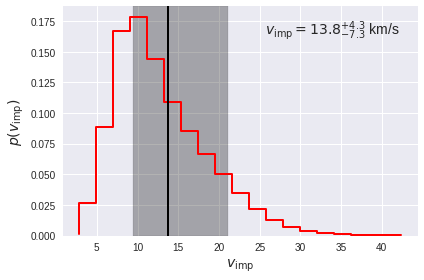

In [0]:
#Posterior probability distribution of impact velocities
data=np.loadtxt(BDIR+"data/vimp-marginal.dat")
vimps=data[:,0]
pvs=data[:,1]
v1,vm,v2=ipercs(vimps,pvs,[15.0,50.0,85.0])
mv=vm-v1;pv=v2-vm

#Plot
fig=plt.figure()
ax=fig.gca()

ax.step(vimps,pvs,color='r',lw=2)

ax.set_xlabel(r"$v_{\rm imp}$",fontsize=14)
ax.set_ylabel(r"$p(v_{\rm imp})$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

#ax.set_title("L1-J-21 Impact Velocity",fontsize=18)

ax.text(0.95,0.95,r"$v_{\rm imp}=%.1lf^{+%.1lf}_{-%.1lf}$ km/s"%(vm,mv,pv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-vimp-ppd.png")
plt.show();

### Incident angle statistics

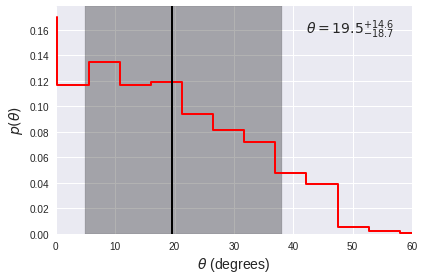

In [0]:
#Posterior probability distribution of impact velocities
data=np.loadtxt(BDIR+"data/elevation-marginal.dat")
angles=data[:,0]
pas=data[:,1]
v1,vm,v2=ipercs(angles,pas,[15.0,50.0,85.0])
mv=vm-v1;pv=v2-vm

#Figure
fig=plt.figure()
ax=fig.gca()

ax.step(angles,pas,color='r',lw=2)

ax.set_xlabel(r"$\theta$ (degrees)",fontsize=14)
ax.set_ylabel(r"$p(\theta)$",fontsize=14)

ax.axvspan(v1,vm,color='k',alpha=0.3)
ax.axvline(vm,color='k',lw=2)
ax.axvspan(vm,v2,color='k',alpha=0.3)

ax.text(0.95,0.95,r"$\theta=%.1lf^{+%.1lf}_{-%.1lf}$"%(vm,mv,pv),
        transform=ax.transAxes,ha='right',va='top',fontsize=14)

ymin,ymax=ax.get_ylim()
ax.set_ylim((0,ymax))
ax.set_xlim((0,60))

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-elevation-ppd.png")

### Distribution of Radiants

In [0]:
#Build 2D histogram
RAmin=0.0;RAmax=360;NRA=20;dRA=(RAmax-RAmin)/NRA
DECmin=-90.0;DECmax=90.0;NDEC=20;dDEC=(DECmax-DECmin)/NDEC

#Run over all combinations
hrd=np.zeros((NDEC,NRA))
pprob=data_rays_prob[:,7]

j=0
P=0
for i in tqdm(range(len(data_rays))):

    #Topocentric coordinates
    Az=data_rays[i,1]
    h=data_rays[i,0]
    p=pprob[i]

    #J2000 coordinates
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,
                   IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    #print(Az,h,RA/15,DEC)
    
    nRA=int((RA-RAmin)/dRA)
    nDEC=int((DEC-DECmin)/dDEC)

    if nRA>=NRA or nDEC>=NDEC:continue
    P+=p
    hrd[nDEC,nRA]+=p
    j+=1
hrd/=P

100%|██████████| 41167/41167 [00:07<00:00, 5526.70it/s]


In [0]:
#Surface of the moon
sRA=[]
sDEC=[]
h=0
for Az in np.linspace(0,360,100):
    RA,DEC=loc2Sky(IMPACT_ET,Az,h,IMPACT_LOC["lon"],IMPACT_LOC["lat"],IMPACT_LOC["alt"],
                   "MOON","IAU_MOON")
    sRA+=[RA]
    sDEC+=[DEC]
sRA=np.array(sRA);sDEC=np.array(sDEC)

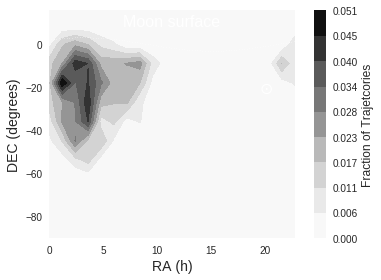

In [0]:
#Map
RAs,DECs=np.meshgrid(np.arange(RAmin,RAmax,dRA),np.arange(DECmin,DECmax,dDEC))
hrd/=hrd.sum()
hmin=hrd.min();hmax=hrd.max()

fig=plt.figure()
ax=fig.gca()


c=ax.contourf(RAs/15.0,DECs,hrd,levels=np.linspace(hrd.min(),hrd.max(),10)) #,cmap="YlOrBr")
cbar=fig.colorbar(c)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ytl=[]
for y in cbar.ax.get_yticks():
    ytl+=["%.3f"%(hmin+y*(hmax-hmin))]
cbar.ax.set_yticklabels(ytl)

#ax.plot(RA_EARTH,DEC_EARTH,'wo')
ax.plot(sRA/15.0,sDEC,'w.',ms=1)

ax.set_ylim((-90.0,5*max(sDEC)))
ax.set_xlim((0,RAs.max()/15.0))

ax.text(RA_EARTH,DEC_EARTH,r'$\odot$',ha='center',va='center',color='w',fontsize=16)
ax.text(0.5,0.95,"Moon surface",ha='center',va='center',transform=ax.transAxes,color='w',fontsize=16)

ax.set_xlabel("RA (h)",fontsize=14)
ax.set_ylabel("DEC (degrees)",fontsize=14)

ax.set_aspect(0.2)
fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-RA_DEC-map.png")

### Orbital Map

In [0]:
amin=0.5;amax=2.5;Na=10;da=(amax-amin)/Na
emin=0.0;emax=1.0;Ne=10;de=(emax-emin)/Ne

hae=np.zeros((Na,Ne))
for i in tqdm(range(Nrays)):
    q=data_rays[i,9]
    e=data_rays[i,10]
    if e>=1:continue
    a=q/(1-e)
    na=int((a-amin)/da)
    ne=int((e-emin)/de)
    if na>=Na or ne>=Ne:continue
    hae[ne,na]+=1
Nt=hae.sum()

100%|██████████| 41167/41167 [00:00<00:00, 310785.65it/s]


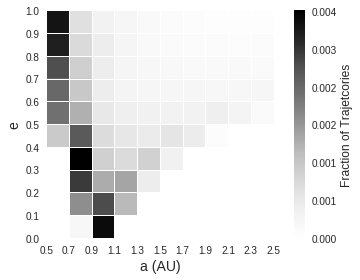

In [0]:
#Figure
hmin=hae.min()/Nt;hmax=hae.max()/Nt

A,E=np.meshgrid(np.arange(amin,amax,da),np.arange(emin,emax,de))
fig=plt.figure()
ax=fig.gca()

im=ax.imshow(hae/Nt,origin='lower')
cbar=fig.colorbar(im)
cbar.ax.set_ylabel('Fraction of Trajetcories',fontsize=12)

ytl=[]
for y in cbar.ax.get_yticks():
    ytl+=["%.3f"%(hmin+y*(hmax-hmin))]
cbar.ax.set_yticklabels(ytl)


ax.set_xlabel("a (AU)",fontsize=14)
ax.set_ylabel("e",fontsize=14)

xts=[]
xtl=[]
for i in np.arange(0.0,Na+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(amin+i*da)]
t=ax.set_xticks(xts)
t=ax.set_xticklabels(xtl)

xts=[]
xtl=[]
for i in np.arange(0.0,Ne+1,1):
    xts+=[i-0.5]
    xtl+=["%.1f"%(emin+i*de)]
t=ax.set_yticks(xts)
t=ax.set_yticklabels(xtl)

fig.tight_layout()
fig.savefig(f"{IMPACT_FIGDIR}/l21j-ae-map.png")

## Photometry

In [0]:
data_rays=np.loadtxt(BDIR+f"data/{IMPACT_DATA}/rays-{IMPACT_SUFFIX}.data.phys")
stars=pd.read_csv(BDIR+f"data/{IMPACT_DATA}/photometry.csv")
for key in "B","V","G":stars[key]=stars[key].apply(lambda x:x.replace(',','.'))
impact=stars.loc[9].copy()
stars.drop(9,inplace=True)

In [0]:
coefs=[]
coefs+=[24.35475129]
coefs+=[0.17248805]
coefs+=[0.44909602]
coefs+=[1.93560511]
G=Gmag(coefs,stars.loc[0,"Red"],stars.loc[0,"Blue"],stars.loc[0,"Green"])
chisq=chiSquare(coefs,stars,True)
print(f"Test G-mag = {G}")
print(f"Test chisquare = {chisq}")

BD+20 2009:Teo=33.69972332247634,Obs=10.4423,dM=23.25742332247634
BD+20 2007:Teo=34.056049744417635,Obs=9.7906,dM=24.265449744417637
BD+20 2005:Teo=34.49825792915905,Obs=8.6293,dM=25.868957929159052
BD+21 1766:Teo=34.581832553795756,Obs=8.3523,dM=26.229532553795757
BD+21 1779:Teo=34.486714433433924,Obs=8.9471,dM=25.539614433433925
BD+21 1777:Teo=33.9232969683706,Obs=9.6792,dM=24.2440969683706
TYC 1385-899-1:Teo=33.61668360857857,Obs=10.0131,dM=23.603583608578568
TYC 1385-939-1:Teo=33.157227102408676,Obs=10.3526,dM=22.804627102408674
Test G-mag = 34.470555354112335
Test chisquare = (1921655.7891592998, [23.25742332247634, 24.265449744417637, 25.868957929159052, 26.229532553795757, 25.539614433433925, 24.2440969683706, 23.603583608578568, 22.804627102408674])


In [0]:
#Minimize
solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)
print(solution)

#Test Solution
chisq,dGs=chiSquare(solution.x,stars,verbose=True)
dG=np.mean(dGs)
print(f"Mean magnitude fit error:{dG}")

      fun: 6.602885445329023
 hess_inv: array([[ 0.06698195,  0.00699168,  0.00090023, -0.02570257],
       [ 0.00699168,  0.0129817 , -0.00216382, -0.01288454],
       [ 0.00090023, -0.00216382,  0.00267151, -0.00069478],
       [-0.02570257, -0.01288454, -0.00069478,  0.02058352]])
      jac: array([ 1.19209290e-07,  9.83476639e-06, -1.07288361e-06, -2.98023224e-07])
  message: 'Optimization terminated successfully.'
     nfev: 144
      nit: 11
     njev: 24
   status: 0
  success: True
        x: array([23.66200602,  0.42782381,  1.73859742, -5.90735497])
BD+20 2009:Teo=10.403369163941665,Obs=10.4423,dM=0.03893083605833425
BD+20 2007:Teo=9.831578783909428,Obs=9.7906,dM=0.040978783909428884
BD+20 2005:Teo=8.708466372595193,Obs=8.6293,dM=0.07916637259519277
BD+21 1766:Teo=8.31202493400567,Obs=8.3523,dM=0.040275065994329395
BD+21 1779:Teo=8.91835055823893,Obs=8.9471,dM=0.02874944176106986
BD+21 1777:Teo=9.622781942377653,Obs=9.6792,dM=0.05641805762234675
TYC 1385-899-1:Teo=10.04996796

In [0]:
#Minimize
solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)
print(solution)

#Test Solution
chisq,dGs=chiSquare(solution.x,stars,verbose=True)
dG=np.mean(dGs)
print(f"Mean magnitude fit error:{dG}")

      fun: 6.602885445297727
 hess_inv: array([[ 0.06559755, -0.00046755, -0.00226069, -0.01462278],
       [-0.00046755,  0.00548479, -0.00218686, -0.0032731 ],
       [-0.00226069, -0.00218686,  0.00463258, -0.00178143],
       [-0.01462278, -0.0032731 , -0.00178143,  0.00896781]])
      jac: array([0.00000000e+00, 2.46763229e-05, 1.57952309e-05, 1.43647194e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 612
      nit: 11
     njev: 100
   status: 2
  success: False
        x: array([23.66200566,  0.42782257,  1.73859671, -5.9073529 ])
BD+20 2009:Teo=10.403369163962093,Obs=10.4423,dM=0.03893083603790615
BD+20 2007:Teo=9.83157870750269,Obs=9.7906,dM=0.04097870750269017
BD+20 2005:Teo=8.708466373250204,Obs=8.6293,dM=0.07916637325020304
BD+21 1766:Teo=8.312025000229124,Obs=8.3523,dM=0.04027499977087601
BD+21 1779:Teo=8.918350574768521,Obs=8.9471,dM=0.02874942523147972
BD+21 1777:Teo=9.622781879238527,Obs=9.6792,dM=0.05641812076147268
TYC 1385-

In [0]:
#Minimize
solution=minimize(chiSquare,coefs,args=(stars,False),tol=1e-5)
print(solution)

#Test Solution
chisq,dGs=chiSquare(solution.x,stars,verbose=True)
dG=np.mean(dGs)
print(f"Mean magnitude fit error:{dG}")

      fun: 6.602885449167282
 hess_inv: array([[ 0.06378907,  0.00068642, -0.00071408, -0.00731201],
       [ 0.00068642,  0.01668852,  0.00753168, -0.02450347],
       [-0.00071408,  0.00753168,  0.00496006, -0.0124912 ],
       [-0.00731201, -0.02450347, -0.0124912 ,  0.03812656]])
      jac: array([0.00000000e+00, 1.57356262e-05, 3.75509262e-06, 1.51991844e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 203
      nit: 10
     njev: 32
   status: 2
  success: False
        x: array([23.66202139,  0.18580187,  0.75506325, -2.56553377])
BD+20 2009:Teo=10.40336964795436,Obs=10.4423,dM=0.03893035204563944
BD+20 2007:Teo=9.831578774493131,Obs=9.7906,dM=0.04097877449313181
BD+20 2005:Teo=8.708465595281524,Obs=8.6293,dM=0.07916559528152334
BD+21 1766:Teo=8.312023963832225,Obs=8.3523,dM=0.040276036167774976
BD+21 1779:Teo=8.918349790545427,Obs=8.9471,dM=0.028750209454573294
BD+21 1777:Teo=9.622782118746109,Obs=9.6792,dM=0.05641788125389091
TYC 1385

In [0]:
m=Gmag(solution.x,impact["Red"],impact["Blue"],impact["Green"],impact["Row"],impact["Col"])
print(f"Magnitude without exposure correction:",m)

Magnitude without exposure correction: 11.608515459800959


In [0]:
#Exposure time of the reference stars
TEXP=20.0
#Corrected magnitude by exposure
G=m-2.5*np.log10(TEXP/IMPACT_FLASH)
print(f"Total average G mag of the flash: {G}")

Total average G mag of the flash: 7.048743607440161


## Energy of the impact

In [0]:
#Luminous energy
f=2
Er=NG*10**((-G+G0)/2.5)*DLAMBDA*f*np.pi*(MOON_DISTANCE*1e3)**2*IMPACT_FLASH
logEr=np.log10(Er)
dlogEr=dG/G*logEr
print(f"Luminous energy (log): {logEr} +/- {dlogEr}")

Luminous energy (log): 6.596511787833981 +/- 0.038457124622038805


In [0]:
#Luminous efficiency
logeta_min=np.log10(1.8e-3)
logeta_max=np.log10(3.4e-3)
logeta_mean=(logeta_min+logeta_max)/2
dlogeta=logeta_mean-logeta_min

In [0]:
#Kinetic energy
logK=logEr-logeta_mean
dlogK=np.sqrt(dlogEr**2+dlogeta**2)
print(f"Kinetic energy (log): {logK} +/- {dlogK}")
print(f"Range of kinetic energy in tons: {10**(logK-dlogK)/TTNT}-{10**(logK+dlogK)/TTNT} tons of TNT")

Kinetic energy (log): 9.2031360767612 +/- 0.14335775505092882
Range of kinetic energy in tons: 0.27427526658726603-0.5307648524935044 tons of TNT


## Meteoroid and crater size

### Random values of primary quantities 

In [0]:
#Generate random values of the key quantities
N=1000
#Random kinetic energy
logKs=np.random.normal(logK,dlogK,N)
Ks=10**logKs
#Random impact speed
vrs=randomX(vimps,pvs,N)
#Random impact angle
thetas=randomX(angles,pas,N)
#Random densities
u=np.random.rand(N)
rhos=np.zeros(N)
rhos[(u<0.01)]=1000
rhos[(u>=0.01)*(u<0.59)]=2500
rhos[(u>=0.59)]=3700

### Derived quantities

In [0]:
#Mass
Ms=2*Ks/(vrs*1e3)**2
logMs=np.log10(Ms)
#Diameter
Ds=2*(3*Ms/(3*np.pi*rhos))**(1./3)
#Crater diameter
dcs=0.25*rhos**(1./6.)*RHO_REG**(-0.5)*Ks**0.29*(np.sin(thetas*DEG))**(1./3.)

In [0]:
#Basic statistics
print(f"Median impactor mass: {np.percentile(Ms,50)} kg")
print(f"Median impactor diameter: {np.percentile(Ds,50)} m")
print(f"Median crater size: {np.percentile(dcs,50)} m")

Median impactor mass: 16.55680213629568 kg
Median impactor diameter: 0.24315657326119083 m
Median crater size: 7.3798058635615345 m


### Posterior probability distributions

Generating statistics of logMs...
	Value: $\log(M)$$=1.2^{+0.39}_{-0.36}$ [kg]
	Creating figure file .//figures/grt-20190121044138-7AE3F0//l21j-logMs-ppd.png


/Users/jzuluaga/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


Generating statistics of Ds...
	Value: $D$$=0.2^{+0.06}_{-0.08}$ m
	Creating figure file .//figures/grt-20190121044138-7AE3F0//l21j-Ds-ppd.png
Generating statistics of dcs...
	Value: $d$$=7.4^{+2.69}_{-2.04}$ m
	Creating figure file .//figures/grt-20190121044138-7AE3F0//l21j-dcs-ppd.png


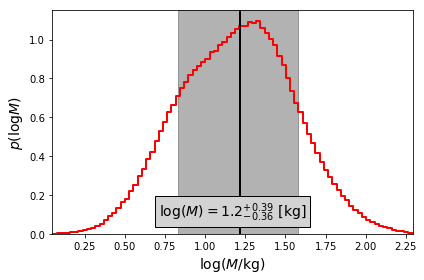

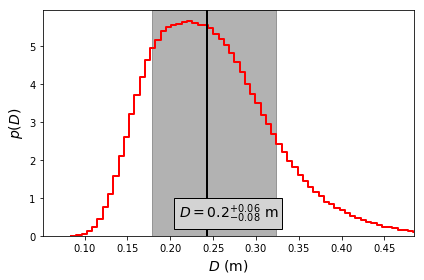

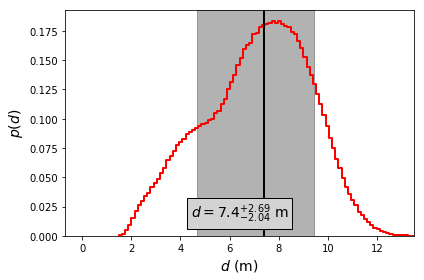

In [0]:
properties=[
    dict(name="$\log(M)$",units="[kg]",symbol="logMs",xlabel=r"$\log(M/{\rm kg})$",ylabel=r"$p(\log M)$"),
    dict(name="$D$",units="m",symbol="Ds",xlabel=r"$D$ (m)",ylabel=r"$p(D)$"),
    dict(name="$d$",units="m",symbol="dcs",xlabel=r"$d$ (m)",ylabel=r"$p(d)$"),
]
plt.ioff()
for q in properties[:]:
    
    print(f"Generating statistics of {q['symbol']}...")
    
    #Statistics
    exec(f"vs=deepcopy({q['symbol']})")
    exec(f"hs,xs=np.histogram({q['symbol']},100,normed=True)")
    xms=(xs[1:]+xs[:-1])/2
    #Error
    x1,xm,x2=np.percentile(vs,[15,50,85])
    mv=xm-x1;pv=x2-xm
    x1,xm,x2

    #Plot distributions
    fig=plt.figure()
    ax=fig.gca()
    ax.step(xms,hs,color='r',lw=2)

    ax.set_xlabel(q["xlabel"],fontsize=14)
    ax.set_ylabel(q["ylabel"],fontsize=14)

    ax.axvspan(x1,xm,color='k',alpha=0.3)
    ax.axvline(xm,color='k',lw=2)
    ax.axvspan(xm,x2,color='k',alpha=0.3)

    value=r"%s$=%.1lf^{+%.2lf}_{-%.2f}$ %s"%(q["name"],xm,mv,pv,q["units"])
    print(f"\tValue: {value}")
    ax.text(0.5,0.1,value,
            transform=ax.transAxes,ha='center',va='center',fontsize=14,bbox=dict(facecolor='lightgray'))

    ymin,ymax=ax.get_ylim()
    ax.set_ylim((0,ymax))
    ax.set_xlim((x1-2*mv,x2+2*pv))
    fname=f"{IMPACT_FIGDIR}/l21j-{q['symbol']}-ppd.png"
    print(f"\tCreating figure file {fname}")
    fig.savefig(fname)
    fig.tight_layout()
    del(fig)

# Parallax Calculation

## Useful routines

In [0]:
import math
from scipy import optimize
import pandas as pd
import numpy as np

# Get (RA,Dec) relative to center of frame from (X,Y) given plate constant parameters
def getradec(plateconst,x,y,xcen,ycen):
    dec = plateconst[3]*(x-xcen)+plateconst[4]*(y-ycen)+plateconst[5]
    ra = 15*math.cos(math.radians(dec))*(plateconst[0]*(x-xcen)-plateconst[1]*(y-ycen))+plateconst[2]
    return ra,dec

# Calculate distance squared for positions given plate constant and star coordinates
def distsq(plateconst,stars=None,verbose=False):
    distsq=0
    drasq=[]
    ddecsq=[]
    #print(stars.loc[N_ref])
    for ind in stars.index[0:N_ref]:
        star=stars.loc[ind]
        #print(star)
        ra,dec=getradec(plateconst,star["X"],star["Y"],stars.loc[N_ref+1]["X"],stars.loc[N_ref+1]["Y"])
        drasq+=[(15*math.cos(math.radians(dec)))**2*(ra-star["RA"])**2]
        ddecsq+=[(dec-star["Dec"])**2]
        #if verbose:print(star['StarName'],star['RA'],star['Dec'],star['X'],star['Y'])
        distsq+=drasq[-1]+ddecsq[-1]
    if verbose:return distsq,drasq,ddecsq
    return distsq

# Get (RA,Dec) given selenographic coordinate (lat,lon)
def selenographictoradec(params,lat,lon):
  ra = params[0]*math.sin(math.radians(lon-params[7]))*math.cos(math.radians(lat-params[6]))+params[1]*math.sin(math.radians(lat-params[6]))+params[2]
  dec = params[3]*math.sin(math.radians(lon-params[6]))*math.cos(math.radians(lat-params[6]))+params[4]*math.sin(math.radians(lat-params[6]))+params[5]
  return ra,dec

# Calculates the error between selenographictoradec conversion and (raref,decref) given params
def selenerr(coord,raref,decref,params):
    ra,dec=selenographictoradec(params,coord[0],coord[1])
    return (15*math.cos(math.radians(dec)))**2*(ra-raref)**2+(dec-decref)**2
    
# Calculate Error Squared for each RA,Dec conversion from selenographic coordinate
def selensq(params,sra=None,sdec=None,slat=None,slon=None,verbose=False):
  selensq=0
  srasq=[]
  sdecsq=[]
  for ind in range(len(sra)):
    ra,dec=selenographictoradec(params,slat[ind],slon[ind])
    srasq+=[(15*math.cos(math.radians(dec)))**2*(ra-sra[ind])**2]
    sdecsq+=[(dec-sdec[ind])**2]
    selensq+=srasq[-1]+sdecsq[-1]
    if verbose and False:
      print(ind)
      print("\t",slat[ind],slon[ind])
      print("\t",sra[ind],sdec[ind])
      print("\t",ra,dec)
      print("\t",srasq[-1],sdecsq[-1])
  if verbose: return selensq,srasq,sdecsq
  return selensq
	
# Get apparent coordinate (RA,Dec) of observer at (lat,lon,ele) given the parallaxconst=(moon distance in Earth radii,geocentric RA,geocentric Dec)
def getparallax(parallaxconst,lat,lon,ele):
	LST=GST+lon/15
	HA=(LST-parallaxconst[1])*15
	rhosin=0.996647*math.sin(math.atan(0.996647*math.tan(math.radians(lat))))+ele/6378160*math.sin(math.radians(lat))
	rhocos=math.cos(math.atan(0.996647*math.tan(math.radians(lat))))+ele/6378160*math.cos(math.radians(lat))
	deltara=math.degrees(math.atan(rhocos*math.sin(math.radians(HA))/(parallaxconst[0]*math.cos(math.radians(parallaxconst[2]))-rhocos*math.cos(math.radians(HA)))))
	ra=parallaxconst[1]-deltara/15
	dec=math.degrees(math.atan(math.cos(math.radians(HA+deltara))*((parallaxconst[0]*math.sin(math.radians(parallaxconst[2]))-rhosin)/(parallaxconst[0]*math.cos(math.radians(parallaxconst[2]))*math.cos(math.radians(HA))-rhocos))))
	return ra,dec
	
# Calculate Error Squared for each parallax correction
def parallaxsq(parallaxconst,mra=None,mdec=None,verbose=False):
	parallaxsq=0
	prasq=[]
	pdecsq=[]
	for ind in range(len(mra)):
		ra,dec=getparallax(parallaxconst,Latitude[ind],Longitude[ind],Elevation[ind])
		prasq+=[(15*math.cos(math.radians(dec)))**2*(ra-mra[ind])**2]
		pdecsq+=[(dec-mdec[ind])**2]
		parallaxsq+=prasq[-1]+pdecsq[-1]
	if verbose: return parallaxsq,prasq,pdecsq
	return parallaxsq


## Constants

In [0]:
# List of all the filenames
filename=[]
BDIR=f"gdrive/My Drive/{DATADIR}/data/moonimpact-images/Parallax/"
#BDIR="data/moonimpact-images/Parallax/"
filename+=[f"{BDIR}data/FritzPichardo-SantoDomingo_RepublicaDominicana.csv"]
#"""
filename+=[f"{BDIR}data/PetrHoralek-BoaVista_CapeVerde.csv"]
filename+=[f"{BDIR}data/GregHogan-Georgia_USA.csv"]
filename+=[f"{BDIR}data/FritzHelmutHemmerich-SantacruzdeTenerif_CanaryIslands.csv"]
filename+=[f"{BDIR}data/LiborHaspl-VelkyOsek_Czec.csv"]
filename+=[f"{BDIR}data/RobertEderArtis-Vienna_Austria.csv"]
filename+=[f"{BDIR}data/SighardSchrablerUlrikeLoffler-Karben_Germany.csv"]
#"""

GST=12.71279 #The Greenwich Sidereal Time at the moment of impact

plateconst=[-1.e-6,-1.e-7,8.16,-1.e-5,-1.e-4,19.7] #Initialize the plate constant

Latitude=[18.43567,16.14361,32.51667,28.14169,50.09820,48.25000,50.21615] #List of latitudes of each observation
Longitude=[-69.96872,-22.86400,-83.65444,-16.6220,15.18885,16.21700,8.79607] #List of longitudes of each observation
Elevation=[26,55,107,1187,192,450,140] #List of elevation of each observation in units of m

N_ref=9 #number of referencer stars
stars=pd.read_csv(filename[0])
N_lunar=len(stars)-N_ref #number of lunar features

#Initialize the array to store ra and dec of center, meteor, and lamark crater
raarray=[[0 for x in range(len(filename))] for y in range(N_lunar)]
decarray=[[0 for x in range(len(filename))] for y in range(N_lunar)]

#Moon features=[ByrgiusA,Grimaldi,Aristachus,Plato,Tycho,Copernicus,Manilius,Dionysus,Chladni,Kepler,Bullialdus]
SLatitude=[-24.54,-5.53,23.69,51.64,-43.4,9.64,14.44,2.77,3.47,8.15,-20.75] #List of selenographic latitudes for each surface feature
SLongitude=[-63.83,-68.26,-47.49,-9.3,-11.26,-20.06,9.06,17.29,-0.23,-37.99,-22.30] #List of selenographic longitudes for each surface feature
initialseleneparams=[-0.02,0.005,8.17,0.07,0.27,20.43,-2.5,-0.8]
initialcoord=[-29.,-68.]

## Converting (X,Y) to (RA,Dec) for each file

In [10]:
for i in range(len(filename)):
    #if i!=1:continue
    stars=pd.read_csv(filename[i]) #Read csv file
    print('###############################################################################')
    print('Reading File:'+filename[i])
    print(stars)
    center=stars.loc[N_ref] #Line 9 store the approximate center position of the moon to serve as initial guess for plateconst[2,5]
    #print(center)
    plateconst[2]=center["RA"]
    plateconst[5]=center["Dec"]
    #print(plateconst)
    
    #dist,dra,ddec=distsq(plateconst,stars,verbose=True);print(dist,dra,ddec);break
    
    solutionplate=optimize.minimize(distsq,plateconst,args=(stars,False)) #Find (X,Y) to (RA,Dec) map by least square fitting
    dist,dra,ddec=distsq(solutionplate.x,stars,verbose=True)
    print('Calculating the plate constant')
    print('RMS in RA: {0:.5e}, Dec: {1:.5e}, Overall: {2:.5e}'.format(math.sqrt(np.mean(dra)),math.sqrt(np.mean(ddec)),math.sqrt(dist/len(ddec))))
    for j in range(N_lunar):
        ra,dec=getradec(solutionplate.x,stars.loc[j+N_ref]["X"],stars.loc[j+N_ref]["Y"],stars.loc[N_ref+1]["X"],stars.loc[N_ref+1]["Y"])
        raarray[j][i]=ra
        decarray[j][i]=dec
        print('The (RA, Dec) for '+stars.loc[j+N_ref]["StarName"]+' is ({0},{1})'.format(ra,dec))
    seleneparams=initialseleneparams
    seleneparams[2]=raarray[0][i]
    seleneparams[5]=decarray[0][i]
    solutionselenographic=optimize.minimize(selensq,seleneparams,args=([row[i] for row in raarray][2:],[row[i] for row in decarray][2:],SLatitude,SLongitude,False)) #Find parameters for selenographic<->geocentric conversion
    #print(solutionselenographic)
    selendist,sdra,sddec=selensq(solutionselenographic.x,[row[i] for row in raarray][2:],[row[i] for row in decarray][2:],SLatitude,SLongitude,True)
    print('Calculating the selenographic coordinate transformation')
    print('RMS in RA: {0:.5e}, Dec: {1:.5e}, Overall: {2:.5e}'.format(math.sqrt(np.mean(sdra)),math.sqrt(np.mean(sddec)),math.sqrt(selendist/len(sddec))))
    selencoordsolution=optimize.minimize(selenerr,[0.,0.],args=(raarray[0][i],decarray[0][i],solutionselenographic.x))
    print('The coordinate for the center of the Moon (Lat,Lon) is ({0:.3f},{1:.3f})'.format(selencoordsolution.x[0],selencoordsolution.x[1]))
    selencoordsolution=optimize.minimize(selenerr,initialcoord,args=(raarray[1][i],decarray[1][i],solutionselenographic.x))
    print('The selenographic coordinate (Lat,Lon) of '+stars.loc[10]["StarName"]+' is ({0:.3f},{1:.3f})'.format(selencoordsolution.x[0],selencoordsolution.x[1]))
    #break

###############################################################################
Reading File:gdrive/My Drive/MoonFlashes/data/moonimpact-images/Parallax/data/FritzPichardo-SantoDomingo_RepublicaDominicana.csv
          StarName        RA        Dec     X     Y
0       BD+21 1766  8.141488  20.599672  4138  1119
1       BD+20 2007  8.144487  20.284162  4020  2589
2         HD 67564  8.155318  20.118764  3356  3389
3   TYC 1385-899-1  8.194665  20.305651   752  2652
4       BD+21 1779  8.181601  20.779029  1494   423
5       BD+21 1777  8.179638  20.837952  1609   145
6       BD+20 2009  8.148322  20.277909  3772  2630
7       BD+20 2005  8.136573  20.562724  4467  1274
8   TYC 1385-939-1  8.191051  20.278068   994  2768
9      Moon Center  8.169000  20.473600  2384  1794
10         L1-21-J       NaN        NaN  1562  2712
11       Byrgius A       NaN        NaN  1524  2618
12        Grimaldi       NaN        NaN  1267  2255
13      Aristachus       NaN        NaN  1397  1535
14         

## Calculate Parallax to get geocentric parameters

In [15]:
#Initial conditions for the parallaxconst=(moon distance in Earth radii,geocentric RA,geocentric Dec)
parallaxinitialconst=[56.0,8.17,20.44]
Sra=[]
Sdec=[]

for i in range(N_lunar):
    solutionparallax=optimize.minimize(parallaxsq,parallaxinitialconst,args=(raarray[i],decarray[i],False)) #Find geocentric distance and RA,Dec by least square fitting
    print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
    print('Calculating Parallax measurements of {0}'.format(stars.loc[i+9]["StarName"]))
    geo_dist=solutionparallax.x[0]
    geo_ra=solutionparallax.x[1]
    geo_dec=solutionparallax.x[2]
    print('The geocentric (RA,Dec) is ({0},{1})'.format(geo_ra,geo_dec))
    print('The geocentric distance is {0}'.format(geo_dist*6378.16))
    Sra+=[geo_ra]
    Sdec+=[geo_dec]

seleneparams=initialseleneparams
solutionselenographic=optimize.minimize(selensq,seleneparams,args=(Sra[2:],Sdec[2:],SLatitude,SLongitude,False)) #Find parameters for selenographic<->geocentric conversion
selendist,sdra,sddec=selensq(solutionselenographic.x,Sra[2:],Sdec[2:],SLatitude,SLongitude,True)
initialcoord=[-29.,-68.]
selencoordsolution=optimize.minimize(selenerr,initialcoord,args=(Sra[1],Sdec[1],solutionselenographic.x))
print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
print('Calculating the selenographic coordinate transformation')
print('RMS in RA: {0:.5e}, Dec: {1:.5e}, Overall: {2:.5e}'.format(math.sqrt(np.mean(sdra)),math.sqrt(np.mean(sddec)),math.sqrt(selendist/len(sddec))))
print('The selenographic coordinate (Lat,Lon) of '+stars.loc[10]["StarName"]+' obtained from geocentric coordinate is ({0:.3f},{1:.3f})'.format(selencoordsolution.x[0],selencoordsolution.x[1]))


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating Parallax measurements of Moon Center
The geocentric (RA,Dec) is (8.166746684189867,20.435841467812427)
The geocentric distance is 357266.4634107948
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating Parallax measurements of L1-21-J
The geocentric (RA,Dec) is (8.179972944721657,20.25035562954754)
The geocentric distance is 356591.31938048237
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating Parallax measurements of Byrgius A
The geocentric (RA,Dec) is (8.180433589301876,20.270705110896564)
The geocentric distance is 356419.5449268758
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Calculating Parallax measurements of Grimaldi
The geocentric (RA,Dec) is (8.18405186400677,20.35028998637009)
The geocentric distance is 356263.4152800712
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%